<a href="https://colab.research.google.com/github/KeitaW/Colab-Notebooks/blob/master/210425_EffectOfLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pytorch_lightning

     |████████████████████████████████| 849kB 17.8MB/s 
     |████████████████████████████████| 112kB 36.2MB/s 
     |████████████████████████████████| 829kB 56.4MB/s 
     |████████████████████████████████| 276kB 52.0MB/s 
     |████████████████████████████████| 184kB 48.3MB/s 
     |████████████████████████████████| 1.3MB 55.4MB/s 
     |████████████████████████████████| 296kB 54.9MB/s 
     |████████████████████████████████| 143kB 59.5MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=f688b74fe1fdf2599428dbb4b46d010dcc8a5dfdd3ae21f8fa4dacf6b445530a
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=f5b8b804715624519922f1d785402a763de66b737b356667004e46a6cf5505b3
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built futur

In [26]:
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl

from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import os
from torchvision import datasets, transforms

from torch.optim import Adam

In [23]:
class LitMNISTBase(LightningModule): #LightningModuleの継承が必須

    def __init__(self, data_dir='./'): #初期化が必要なものはここに記載
        super().__init__()
        self.data_dir=data_dir
        self.transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))])
        pass

    def forward(self, x): #推論をする
        pass

    def training_step(self, batch, batch_idx): #trainingする
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log('my_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx): #汎化性能確認のため実施
        x, t = batch
        y = self(x)
        loss = F.nll_loss(y, t)
        preds = torch.argmax(y, dim=1)

        # Calling self.log will surface up scalars for you in TensorBoard
        #log記録；上で定義したself.val_accなどを記録
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc(preds, t), prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx): #testの実行；最終的なlossとaccの確認
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self): #optimizerの定義
        return Adam(self.parameters(), lr=1e-3)    

    def prepare_data(self): #データダウンロード
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None): #train, val, testデータ分割
        # Assign train/val datasets for use in dataloaders
        mnist_full =MNIST(self.data_dir, train=True, transform=self.transform)
        n_train = int(len(mnist_full)*0.8)
        n_val = len(mnist_full)-n_train
        self.mnist_train, self.mnist_val = torch.utils.data.random_split(mnist_full, [n_train, n_val])
        self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self): #trainデータ作成
        # prepare transforms standard to MNIST
        mnist_train = MNIST(self.data_dir, train=True, transform=self.transform)
        return DataLoader(mnist_train, batch_size=64)

    def val_dataloader(self): #valデータ作成
        mnist_val = MNIST(self.data_dir, train=False, transform=self.transform)
        return DataLoader(mnist_val, batch_size=64)

    def test_dataloader(self): #testデータ作成
        mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)
        return DataLoader(mnist_test, batch_size=64)

class LitMNIST1(LitMNISTBase): #LightningModuleの継承が必須

    def __init__(self, data_dir='./'): #初期化が必要なものはここに記載
        super().__init__(data_dir)
        # mnist images are (1, 28, 28) (channels, width, height)
        #ネットワーク定義するための関数；forwardで使う
        self.layer_1 = torch.nn.Linear(28 * 28, 10)

        self.train_acc = pl.metrics.Accuracy()
        self.val_acc = pl.metrics.Accuracy()
        self.test_acc = pl.metrics.Accuracy()

    def forward(self, x): #推論をする
        batch_size, channels, width, height = x.size()
        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)
        x = self.layer_1(x)
        x = F.log_softmax(x)
        return x

class LitMNIST2(LitMNISTBase): #LightningModuleの継承が必須

    def __init__(self, data_dir='./'): #初期化が必要なものはここに記載
        super().__init__(data_dir)
        # mnist images are (1, 28, 28) (channels, width, height)
        #ネットワーク定義するための関数；forwardで使う
        self.layer_1 = torch.nn.Linear(28 * 28, 128)
        self.layer_2 = torch.nn.Linear(128, 10)

        self.train_acc = pl.metrics.Accuracy()
        self.val_acc = pl.metrics.Accuracy()
        self.test_acc = pl.metrics.Accuracy()

    def forward(self, x): #推論をする
        batch_size, channels, width, height = x.size()
        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.log_softmax(x)
        return x

In [15]:
#Gpu利用のためにdevice定義
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#乱数初期値固定
pl.seed_everything(0)
#netを定義
net = LitMNIST1()
#GPUに載せる
model = net.to(device)
#Trainnigの回数などを定義
trainer = Trainer(gpus=1, max_epochs=10)
#fitting（学習）する
trainer.fit(model)
#testデータで検証する
results1 = trainer.test()
#検証結果出力
print(results1)

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | layer_1   | Linear   | 7.9 K 
1 | train_acc | Accuracy | 0     
2 | val_acc   | Accuracy | 0     
3 | test_acc  | Accuracy | 0     
---------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': 0.9150999784469604, 'val_loss': 0.3018198311328888}
--------------------------------------------------------------------------------
[{'val_loss': 0.3018198311328888, 'val_acc': 0.9150999784469604}]


In [24]:
#Gpu利用のためにdevice定義
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#乱数初期値固定
pl.seed_everything(0)
#netを定義
net = LitMNIST2()
#GPUに載せる
model = net.to(device)
#Trainnigの回数などを定義
trainer = Trainer(gpus=1, max_epochs=10)
#fitting（学習）する
trainer.fit(model)
#testデータで検証する
results2 = trainer.test()
#検証結果出力
print(results2)

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | layer_1   | Linear   | 100 K 
1 | layer_2   | Linear   | 1.3 K 
2 | train_acc | Accuracy | 0     
3 | val_acc   | Accuracy | 0     
4 | test_acc  | Accuracy | 0     
---------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_acc': 0.9742000102996826, 'val_loss': 0.08682948350906372}
--------------------------------------------------------------------------------
[{'val_loss': 0.08682948350906372, 'val_acc': 0.9742000102996826}]


<BarContainer object of 2 artists>

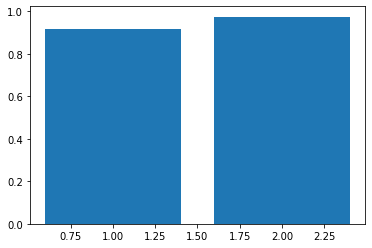

In [29]:
plt.bar([1, 2], [results1[0]["val_acc"], results2[0]["val_acc"]])